<a href="https://colab.research.google.com/github/sean-otoole/HODD/blob/main/PDTx_pipeline/PDTx_05_Validation_DA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update
!apt-get install -y texlive-latex-base texlive-fonts-recommended texlive-fonts-extra texlive-latex-extra cm-super dvipng

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import numpy as np

os.chdir("/content/drive/MyDrive/HODD/validation_data")

In [4]:
gwas_csv = "MONDO_0005180_associations_expo.csv"
del_csv = "perturbation_parkinsons_delete_results.csv"
over_csv = "perturbation_parkinsons_overexpress_results.csv"

gwas_df = pd.read_csv(gwas_csv, encoding = "ISO-8859-1")
del_df = pd.read_csv(del_csv, encoding = "ISO-8859-1")
over_df = pd.read_csv(over_csv, encoding = "ISO-8859-1")

In [5]:
# merge the top hits from the deletion and overexpression dfs
# this df will be the evidence accumulation df
# it will be used throughout this portion of the analysis for selecting a target to follow up on

del_sig_list = del_df[del_df['Sig']==1]['Gene_name'].tolist()
over_sig_list = over_df[over_df['Sig']==1]['Gene_name'].tolist()

union_list = list(set(del_sig_list) | set(over_sig_list))

# ranks the signficance for both screens, useful for categorization later
del_df['sig_rank_del'] = del_df['Goal_end_vs_random_pval'].rank(pct=True)
over_df['sig_rank_over'] = over_df['Goal_end_vs_random_pval'].rank(pct=True)

del_filtered = del_df[del_df['Gene_name'].isin(union_list)][['Gene_name','Shift_to_goal_end','Goal_end_FDR','Sig','sig_rank_del']]
del_filtered = del_filtered.rename(columns={"Shift_to_goal_end": "Shift_to_goal_end_del", "Goal_end_FDR": "Goal_end_FDR_del","Sig": "Sig_del"})

over_filtered = over_df[over_df['Gene_name'].isin(union_list)][['Gene_name','Shift_to_goal_end','Goal_end_FDR','Sig','sig_rank_over']]
over_filtered = over_filtered.rename(columns={"Shift_to_goal_end": "Shift_to_goal_end_over", "Goal_end_FDR": "Goal_end_FDR_over","Sig": "Sig_over"})

target_evidence_df = pd.merge(del_filtered, over_filtered, on='Gene_name')

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

import matplotlib as mpl
plt.rcParams['text.usetex'] = True  # Enable LaTeX rendering for text


from matplotlib.lines import Line2D

# Define custom legend elements
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Sig. in both',
           markerfacecolor='green', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='Sig. in one,\ntop 5% in other',
           markerfacecolor='purple', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Sig. in one screen',
           markerfacecolor='black', markersize=8)
]



def plot_goal_shifts(df, colors, x_col='Shift_to_goal_end_del', y_col='Shift_to_goal_end_over',
                             title="", font_size = 14, filename=None):

    # Set Seaborn theme (grid off)
    #sns.set(style="white", context="talk")  # Removed 'whitegrid' to disable grid
    sns.set(style="ticks", context="talk")  # 'ticks' keeps both gridlines and tick marks visible


    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.scatterplot(data=df, y=y_col, x=x_col, s=40, color=colors, edgecolor=colors, ax=ax, alpha=0.8)

    # Remove gridlines explicitly (just in case)
    ax.grid(False)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add vertical dashed line at x = 0 with further apart dashes
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1,
               dashes=(10, 5))  # Adjust (10, 5) for larger spacing between dashes

    # Add horizontal dashed line as wel
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1,
               dashes=(10, 5))

    ax.set_xticks([-0.15, 0, 0.15])
    ax.set_yticks([-0.15, 0, 0.15])

    # Set consistent font size
    label_fontsize = 12

    ax.set_xlim(-0.17,0.17)
    ax.set_ylim(-0.17,0.17)

    # set a log scale

    # # Apply log scale to both axes
    # ax.set_xscale('symlog', linthresh=0.05)
    # ax.set_yscale('symlog', linthresh=0.05)

    # Apply consistent font sizes and colors to all axis labels and ticks
    ax.set_title(title, fontsize=font_size)
    ax.set_xlabel("Shift towards healthy state, deletion screen", fontsize=font_size)
    ax.set_ylabel("Shift towards healthy state, overexpression screen", fontsize=font_size)
    ax.tick_params(labelsize=font_size)

    ax.tick_params(axis='both', colors='black')  # Tick labels
    ax.xaxis.label.set_color('black')            # X-axis label
    ax.yaxis.label.set_color('black')            # Y-axis label

    # add quadrant labels
    # Get axis limits
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    x_center = 0
    y_center = 0

    # Midpoints in each quadrant
    label_coords = {
        # 'Q1': ((xlim[1] + x_center)/2, (ylim[1] + y_center)/2),  # top-right
        'Healthy-State Enhancers': ((xlim[0] + x_center)/2, (ylim[1] + y_center)/2),  # top-left
        # 'Q3': ((xlim[0] + x_center)/2, (ylim[0] + y_center)/2),  # bottom-left
        'Healthy-State Suppressors': ((xlim[1] + x_center)/2, (ylim[0] + y_center)/2),  # bottom-right
    }

    # Add text labels
    for label, (x, y) in label_coords.items():
        ax.text(x, y, label, fontsize=font_size, color='black',
                ha='center', va='center', fontweight='bold')

    # Add the legend to the plot (top right = 'upper right')
    ax.legend(
    handles=legend_elements,
    loc='upper right',
    frameon=False,
    fontsize=font_size
)

    # Tidy layout and show
    plt.tight_layout()

    if filename:
      plt.savefig(f"{filename}.svg", format="svg")  # Save as svg

    plt.show()

In [7]:
# desfines a tier 1 feature vector, wherein a a hit is significant in both deletion and overexpression

target_evidence_df['Tier_1_pertubration_hit'] = target_evidence_df['Sig_del']+target_evidence_df['Sig_over']-1

In [8]:
# defines a tier 2 feature vector, wherein a hit is signicant in one screen and not another
# however, in the screen that was not significant, the hit falls within the top 5 percent of hits

# Tier 2 for significant deltion hits
only_sig_del_bin = abs(target_evidence_df['Tier_1_pertubration_hit']-1)*target_evidence_df['Sig_del']

sig_rank_thresh_bool_over = target_evidence_df['sig_rank_over']<0.05
sig_rank_thresh_bin_over = sig_rank_thresh_bool_over.astype(int)

tier_2_del = only_sig_del_bin * sig_rank_thresh_bin_over

print(sum(tier_2_del))

# Tier 2 for sigfinficant overexpression hits

only_sig_over_bin = abs(target_evidence_df['Tier_1_pertubration_hit']-1)*target_evidence_df['Sig_over']

sig_rank_thresh_bool_del = target_evidence_df['sig_rank_del']<0.05
sig_rank_thresh_bin_del = sig_rank_thresh_bool_del.astype(int)

tier_2_over = only_sig_over_bin * sig_rank_thresh_bin_del

print(sum(tier_2_over))

# combine into a single column and add to the target_evidence df

target_evidence_df['Tier_2_pertubration_hit'] = tier_2_del + tier_2_over

# establish color vector for the scatter plot

colors = np.full(len(target_evidence_df), 'black', dtype=object)  # allow full strings

colors[target_evidence_df['Tier_1_pertubration_hit'] == 1] = 'green'
colors[target_evidence_df['Tier_2_pertubration_hit'] == 1] = 'purple'

0
178


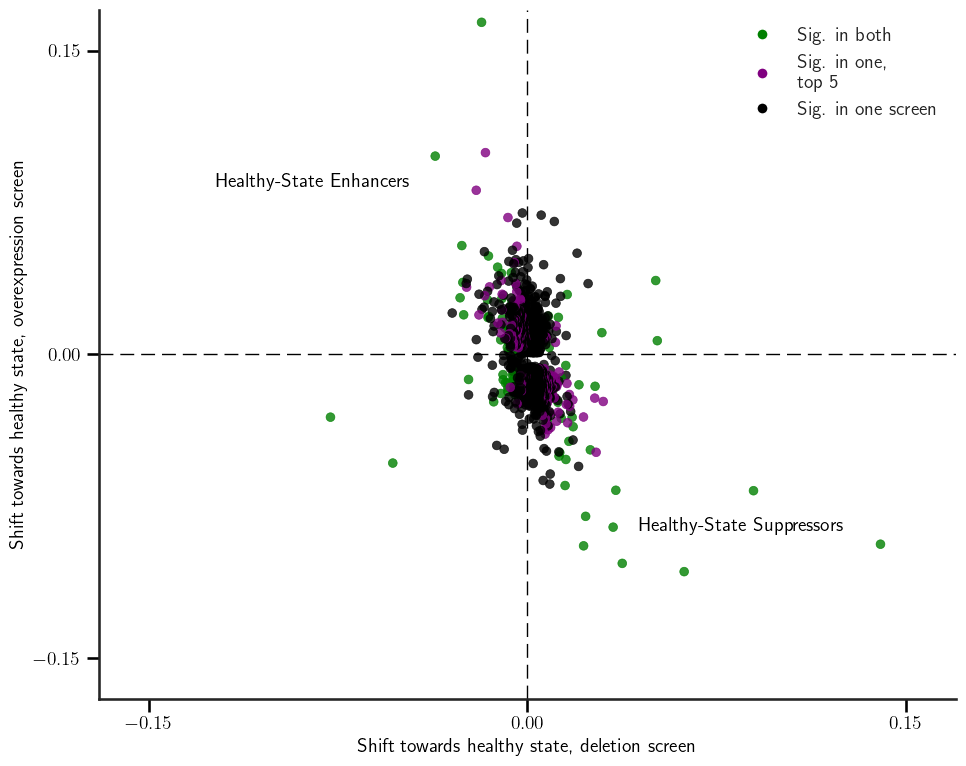

In [9]:
plot_goal_shifts(target_evidence_df, colors)

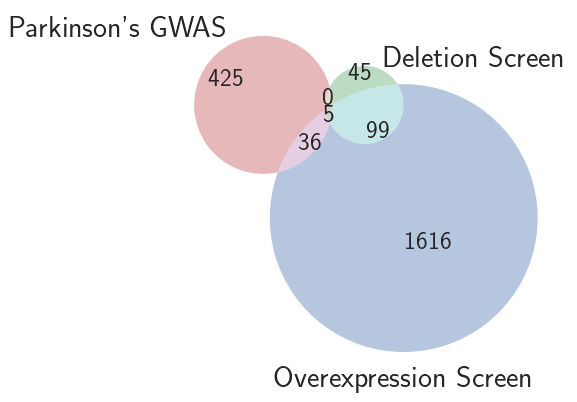

In [10]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Define your three sets
del_list = del_sig_list
over_list = over_sig_list

# the gwas list from the gwas dataframe requires modifications: removing duplicates, and splitting up multiple genes associated with the same allele
gwas_list = gwas_df['mappedGenes'].tolist()
gwas_list = [gene for gene in gwas_list if gene != '-']
gwas_list = [gene.strip() for item in gwas_list for gene in item.split(',')]
gwas_list = list(set(gwas_list))

# Convert to sets
gwas_set = set(gwas_list)
del_set = set(del_list)
over_set = set(over_list)

# Create the Venn diagram
venn3([gwas_set, del_set, over_set], ("Parkinson's GWAS", 'Deletion Screen', 'Overexpression Screen'))

# Show the plot
plt.show()

In [11]:
# add the risk allele identities and counts to the target evidence df

riskAllele_count_list = []
riskAllele_list = []
alleleLocations_list = []

# Loop only over unique genes once
for gene in target_evidence_df['Gene_name']:
    # Create a mask that checks for exact gene match
    mask = gwas_df['mappedGenes'].apply(lambda x: gene in x.split(','))
    matching_rows = gwas_df[mask]

    # Get count and list of riskAlleles
    riskAllele_count_list.append(len(matching_rows))
    riskAllele_list.append(matching_rows['riskAllele'].tolist())
    alleleLocations_list.append(matching_rows['locations'].tolist())

target_evidence_df['gwas_allele_count'] = riskAllele_count_list
target_evidence_df['risk_alleles'] = riskAllele_list
target_evidence_df['risk_alleles_locations'] = alleleLocations_list

# reformat allele locations info

def transform_locations(loc_list):
    return [f"chr{loc.split(':')[0]}_{loc.split(':')[1]}" for loc in loc_list]

target_evidence_df['risk_alleles_locations'] = target_evidence_df['risk_alleles_locations'].apply(transform_locations)

In [63]:
# generate a list for filtering through the eqtl dfs

# Filter non-empty risk_alleles_locations
risk_alleles_locations = target_evidence_df[
    target_evidence_df['risk_alleles_locations'].apply(lambda x: len(x) > 0)
]['risk_alleles_locations']

# Initialize list
risk_alleles_list = []

# Loop through each entry, split, and extend the list

risk_alleles_locations.apply(lambda x: risk_alleles_list.extend(x))

# list for filtering eqtl df

risk_alleles_list = set(risk_alleles_list)

In [ ]:
# next step, improve the brain specific data from the eqtyl v10 dataset you downloaded
# filter each by significance and save them (for the brain dfs)
# then determine the number of loci that are eqtls, in the brin
# dataframe should contain the NES scores for the associated loci

# build a heatmap for each positive eqtl across brain tissues for the top hits

chr1_205744250, chr1_205694350, chr1_205707135, chr1_205750404, chr1_205714227, chr1_205754444


In [13]:
os.chdir("/content/drive/MyDrive/HODD/validation_data/GTEx_Analysis_v10_eQTL_updated")
eqtl_files_list = os.listdir()
eqtl_brain_files = [x for x in eqtl_files_list if "Brain" in x and 'parquet' in x]
eqtl_brain_files

['Brain_Amygdala.v10.eQTLs.signif_pairs.parquet',
 'Brain_Anterior_cingulate_cortex_BA24.v10.eQTLs.signif_pairs.parquet',
 'Brain_Caudate_basal_ganglia.v10.eQTLs.signif_pairs.parquet',
 'Brain_Cerebellar_Hemisphere.v10.eQTLs.signif_pairs.parquet',
 'Brain_Cerebellum.v10.eQTLs.signif_pairs.parquet',
 'Brain_Cortex.v10.eQTLs.signif_pairs.parquet',
 'Brain_Frontal_Cortex_BA9.v10.eQTLs.signif_pairs.parquet',
 'Brain_Hippocampus.v10.eQTLs.signif_pairs.parquet',
 'Brain_Hypothalamus.v10.eQTLs.signif_pairs.parquet',
 'Brain_Nucleus_accumbens_basal_ganglia.v10.eQTLs.signif_pairs.parquet',
 'Brain_Putamen_basal_ganglia.v10.eQTLs.signif_pairs.parquet',
 'Brain_Spinal_cord_cervical_c-1.v10.eQTLs.signif_pairs.parquet',
 'Brain_Substantia_nigra.v10.eQTLs.signif_pairs.parquet']

In [ ]:
!pip install pybiomart

In [16]:
from pybiomart import Server
import pandas as pd

# Connect to the Ensembl Biomart server
server = Server(host='http://www.ensembl.org')

# Use the human dataset from Ensembl Genes
dataset = server.marts['ENSEMBL_MART_ENSEMBL'].datasets['hsapiens_gene_ensembl']

# Query: from gene symbols to Ensembl Gene IDs with version
results = dataset.query(
    attributes=[
        'external_gene_name',        # gene symbol
        'ensembl_gene_id_version',   # ENSG00000069275.13
    ]
)

# Rename for clarity
results.columns = ['gene_name', 'ensembl_gene_id_version']

# Example: grab the relevant genes for filtering

genes_with_loci = target_evidence_df[target_evidence_df['risk_alleles_locations'].apply(lambda x: len(x) > 0)]['Gene_name'].tolist()
filtered = results[results['gene_name'].isin(genes_with_loci)]

ensembl_list_filter = filtered['ensembl_gene_id_version'].tolist()

print(len(ensembl_list_filter))
print(ensembl_list_filter)

55
['ENSG00000102753.10', 'ENSG00000157540.22', 'ENSG00000185950.9', 'ENSG00000038945.15', 'ENSG00000173482.17', 'ENSG00000071189.21', 'ENSG00000151229.13', 'ENSG00000122507.21', 'ENSG00000145685.14', 'ENSG00000151929.10', 'ENSG00000285132.3', 'ENSG00000152128.13', 'ENSG00000136235.17', 'ENSG00000168675.19', 'ENSG00000130511.16', 'ENSG00000088766.12', 'ENSG00000163468.15', 'ENSG00000204287.14', 'ENSG00000281758.1', 'ENSG00000277263.1', 'ENSG00000130203.10', 'ENSG00000138760.11', 'ENSG00000184305.16', 'ENSG00000087274.19', 'ENSG00000112787.14', 'ENSG00000121879.6', 'ENSG00000229074.8', 'ENSG00000230726.9', 'ENSG00000226260.9', 'ENSG00000227993.9', 'ENSG00000236884.8', 'ENSG00000228987.9', 'ENSG00000145349.20', 'ENSG00000196126.12', 'ENSG00000228080.10', 'ENSG00000164733.23', 'ENSG00000206240.11', 'ENSG00000206308.11', 'ENSG00000206306.10', 'ENSG00000185774.17', 'ENSG00000234794.9', 'ENSG00000185477.6', 'ENSG00000185345.25', 'ENSG00000114030.13', 'ENSG00000153707.20', 'ENSG00000108312.16

In [153]:
import gc
import pandas as pd

eqtl_data = {}
eqtl_data_additional = {}
eqtl_data_all = {}


# Create a mapping from Ensembl ID with version → gene symbol
id_to_symbol = dict(zip(results['ensembl_gene_id_version'], results['gene_name']))

for file in eqtl_brain_files:
    # Extract key from filename
    key = file.split('.v10')[0].split('Brain_')[1]

    # Load the dataframe
    filtered_df = pd.read_parquet(file)

    all_df = filtered_df

    # Filter based on genes of interest
    filtered_df = filtered_df[filtered_df['gene_id'].isin(ensembl_list_filter)]

    # Add gene symbol column using .map() for better performance
    filtered_df['gene_symbol'] = filtered_df['gene_id'].map(id_to_symbol)

    # only retain the eqtls that fall within the genes of interest with parkinson's associated point mutations
    filtered_df = filtered_df[filtered_df['variant_id'].apply(lambda x: '_'.join(x.split('_')[0:2])).isin(risk_alleles_list)]

    # remove unneeded paramters
    less_filtered_df = filtered_df[['gene_id','variant_id','tss_distance','slope','gene_symbol']]
    filtered_df = filtered_df[['variant_id','slope']]

    #rename the slop parameter per tissue
    filtered_df = filtered_df.rename(columns={'slope': "_".join([key,'slope'])})

    # Store in dictionary
    eqtl_data_all[key] = all_df
    eqtl_data[key] = filtered_df
    eqtl_data_additional[key] = less_filtered_df

    # Clean up memory
    del filtered_df
    del less_filtered_df
    gc.collect()

<ipython-input-153-e0e78612bdd2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['gene_symbol'] = filtered_df['gene_id'].map(id_to_symbol)
<ipython-input-153-e0e78612bdd2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['gene_symbol'] = filtered_df['gene_id'].map(id_to_symbol)
<ipython-input-153-e0e78612bdd2>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [142]:
from functools import reduce

merged_df = reduce(
    lambda left, right: pd.merge(left, right, on='variant_id', how='outer'),
    eqtl_data.values()
)

# Fill missing slope values with 0
slope_columns = [col for col in merged_df.columns if col != 'variant_id']
merged_df[slope_columns] = merged_df[slope_columns].fillna(0)

In [143]:
# for adding the gene symbols to the merged df for the heatmap plot

#  Build a lookup dict of variant_id → gene_symbol
variant_to_gene = {}

for df in eqtl_data_additional.values():
    submap = df.set_index('variant_id')['gene_symbol'].to_dict()
    variant_to_gene.update(submap)  # adds/overwrites entries

# Step 2: Lookup in one pass
gene_symbol_column_list = [variant_to_gene.get(variant, None) for variant in merged_df['variant_id']]

merged_df['gene_symbol'] = gene_symbol_column_list

In [141]:
merged_df

,variant_id,Amygdala_slope,Anterior_cingulate_cortex_BA24_slope,Caudate_basal_ganglia_slope,Cerebellar_Hemisphere_slope,Cerebellum_slope,Cortex_slope,Frontal_Cortex_BA9_slope,Hippocampus_slope,Hypothalamus_slope,Nucleus_accumbens_basal_ganglia_slope,Putamen_basal_ganglia_slope,Spinal_cord_cervical_c-1_slope,Substantia_nigra_slope,gene_symbol
0,chr12_39959194_T_C_b38,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.254518,0.000000,0.000000,0.000000,0.0,0.000000,SLC2A13
1,chr1_205750404_G_A_b38,0.000000,-0.145162,-0.112390,-0.125091,-0.111321,-0.094973,0.000000,-0.149383,0.000000,0.000000,-0.110561,0.0,0.000000,NUCKS1
2,chr1_205754444_C_T_b38,0.000000,-0.145162,-0.112390,-0.125091,-0.111321,-0.094973,0.000000,-0.149383,0.000000,0.000000,-0.110561,0.0,0.000000,NUCKS1
3,chr20_6025395_C_T_b38,0.000000,0.000000,-0.316766,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,CRLS1
4,chr21_37398228_T_C_b38,0.000000,0.000000,0.000000,0.000000,0.199627,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,DYRK1A
5,chr21_37480059_G_A_b38,0.000000,0.000000,0.000000,0.000000,0.198064,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,DYRK1A
6,chr2_134681219_G_A_b38,0.000000,-0.361504,0.000000,0.000000,0.000000,-0.288823,-0.337458,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,TMEM163
7,chr4_76226816_A_G_b38,0.000000,0.000000,0.090683,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,SCARB2
8,chr7_23254127_A_G_b38,-0.898444,-0.768294,-0.807023,-0.663927,-0.550945,-0.558077,-0.699815,-0.628926,-0.690114,-0.819482,-0.825980,0.0,-0.432072,GPNMB
9,chr7_23260430_A_C_b38,-0.854807,-0.768294,-0.790006,-0.650937,-0.542192,-0.561303,-0.695794,-0.614034,-0.683590,-0.804658,-0.823998,0.0,-0.388302,GPNMB


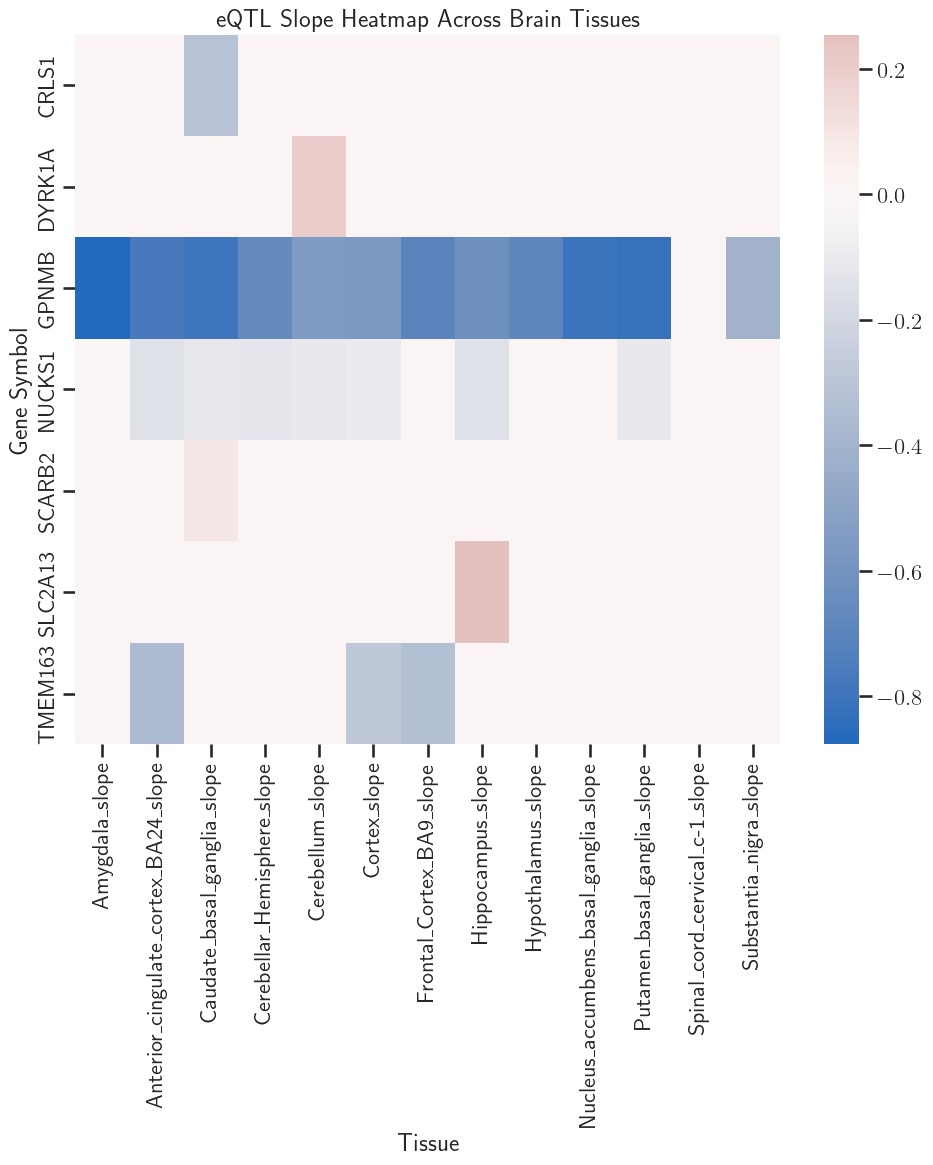

In [145]:
# Set the index to gene_symbol, and select only slope columns
slope_cols = [col for col in merged_df.columns if col not in ['variant_id', 'gene_symbol']]
heatmap_data = merged_df.set_index('gene_symbol')[slope_cols]

#averages the columns with the same gene symbol, these values are actually idenetical anyway
heatmap_data = heatmap_data.groupby(heatmap_data.index).mean()

# # Optional: aggregate if multiple rows per gene_symbol (e.g., mean)
# heatmap_data = heatmap_data.groupby(heatmap_data.index).mean()

# plot the heatmap
plt.figure(figsize=(10, 12))  # adjust size as needed
sns.heatmap(heatmap_data, cmap='vlag', center=0)
plt.title("eQTL Slope Heatmap Across Brain Tissues")
plt.xlabel("Tissue")
plt.ylabel("Gene Symbol")
plt.tight_layout()

In [144]:
slope_cols = [col for col in merged_df.columns if col not in ['variant_id', 'gene_symbol']]

slope_cols

['Amygdala_slope',
 'Anterior_cingulate_cortex_BA24_slope',
 'Caudate_basal_ganglia_slope',
 'Cerebellar_Hemisphere_slope',
 'Cerebellum_slope',
 'Cortex_slope',
 'Frontal_Cortex_BA9_slope',
 'Hippocampus_slope',
 'Hypothalamus_slope',
 'Nucleus_accumbens_basal_ganglia_slope',
 'Putamen_basal_ganglia_slope',
 'Spinal_cord_cervical_c-1_slope',
 'Substantia_nigra_slope']

In [148]:
target_evidence_df[target_evidence_df['Gene_name'] == 'GPNMB']

,Gene_name,Shift_to_goal_end_del,Goal_end_FDR_del,Sig_del,sig_rank_del,Shift_to_goal_end_over,Goal_end_FDR_over,Sig_over,sig_rank_over,Tier_1_pertubration_hit,Tier_2_pertubration_hit,gwas_allele_count,risk_alleles,risk_alleles_locations
90,GPNMB,-0.005452,0.027099,1,0.009094,0.002458,0.016203,1,0.087932,1,0,4,"[rs199347-A, rs199347-A, rs199351-A, rs199351-A]","[chr7_23254127, chr7_23254127, chr7_23260430, ..."


In [151]:

 eqtl_data_additional['Caudate_basal_ganglia']

,gene_id,variant_id,tss_distance,slope,gene_symbol
112986,ENSG00000069275.13,chr1_205750404_G_A_b38,222,-0.112390,NUCKS1
112988,ENSG00000069275.13,chr1_205754444_C_T_b38,4262,-0.112390,NUCKS1
372142,ENSG00000138760.11,chr4_76226816_A_G_b38,-7720,0.090683,SCARB2
722345,ENSG00000136235.17,chr7_23254127_A_G_b38,18160,-0.807023,GPNMB
722353,ENSG00000136235.17,chr7_23260430_A_C_b38,24463,-0.790006,GPNMB
1604993,ENSG00000088766.12,chr20_6025395_C_T_b38,19302,-0.316766,CRLS1


In [161]:
eqtl_data_all[eqtl_data_all['Caudate_basal_ganglia']['variant_id'] == 'chr20_6025395_C_T_b38']

TypeError: unhashable type: 'Series'

In [170]:
eqtl_data_all['Caudate_basal_ganglia'].loc[
    eqtl_data_all['Caudate_basal_ganglia']['variant_id'] == 'chr20_6025395_C_T_b38'
]

,gene_id,variant_id,tss_distance,af,ma_samples,ma_count,pval_nominal,slope,slope_se,pval_nominal_threshold,min_pval_nominal,pval_beta
1604993,ENSG00000088766.12,chr20_6025395_C_T_b38,19302,0.102349,56,61,2.653654e-08,-0.316766,0.05508,0.000074,7.607480e-10,0.000005


In [171]:
target_evidence_df

,Gene_name,Shift_to_goal_end_del,Goal_end_FDR_del,Sig_del,sig_rank_del,Shift_to_goal_end_over,Goal_end_FDR_over,Sig_over,sig_rank_over,Tier_1_pertubration_hit,Tier_2_pertubration_hit,gwas_allele_count,risk_alleles,risk_alleles_locations
0,HSP90AA1,0.140043,5.730000e-114,1,0.000137,-0.093749,4.200000e-56,1,0.000479,1,0,0,[],[]
1,MT-ND4,0.089671,5.810000e-117,1,0.000068,-0.067334,4.750000e-72,1,0.000274,1,0,0,[],[]
2,HSP90AB1,0.062161,2.270000e-62,1,0.000274,-0.107297,2.090000e-77,1,0.000205,1,0,0,[],[]
3,CRYAB,0.051508,2.930000e-25,1,0.000821,0.006732,1.036225e-03,1,0.048957,1,0,0,[],[]
4,PNISR,0.050882,2.710000e-79,1,0.000205,0.036428,9.050000e-60,1,0.000410,1,0,0,[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1796,UHRF1,-0.020320,6.460366e-01,0,0.044991,0.080989,2.813198e-02,1,0.100991,0,1,0,[],[]
1797,C8orf34,-0.023863,7.509435e-01,0,0.079932,0.037101,3.069105e-02,1,0.103795,0,0,0,[],[]
1798,CCDC65,-0.024150,6.237531e-02,0,0.010872,0.033148,2.810000e-07,1,0.018530,0,1,0,[],[]
1799,TUSC3,-0.024299,8.478158e-01,0,0.255795,0.034962,8.370460e-03,1,0.075214,0,0,0,[],[]


In [172]:
# need to inforporate information about the direction of the allele's that are risk allele's, this should flip the NES value